- 姓名：林芷翎
- 學號：711133123
- 作品目標：本研究以AT&T人臉資料集為探討對象，使用三種不同的分類器對原始資料及經主成分分析後的資料進行分類。研究中針對不同的參數設計進行探討，並進一步探討參數如何影響分類結果。

讀取相關套件

In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier

讀取與切割資料
- AT&T人臉資料集，包含400張照片(40個人各10張照片)、 4096(64*64)項像素值與一項類別變數（target）
- 將資料的70%切分為訓練資料，30%切分為測試集資料

In [14]:
df = pd.read_csv('data/face_data.csv')
X = np.array(df.iloc[:, :-1])
y = np.array(df.iloc[:, -1])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

呈現出前兩位的人臉影像，資料包含不同表情與角度

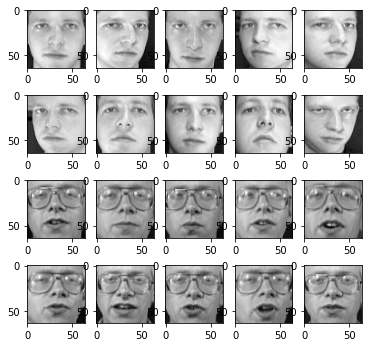

In [15]:
fig, axes = plt.subplots(4, 5, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(np.array(X)[i].reshape(64, 64), cmap='gray')
plt.show()

#### 一、多元羅吉斯迴歸（Multiple logistic regression analysis）

1. 將原始資料使用優化器（lbfgs）透過羅吉斯迴歸進行分類任務  
&rarr; 當使用羅吉斯迴歸對所有資料進行分類時，高維度的情況下花費3分39秒的時間，準確率高達96%。

In [22]:
opts = dict(tol = 1e-6, max_iter = int(1e6), verbose = 0) # verbose = 0不輸出迭代過程
solver = 'lbfgs' 
clf_original = LogisticRegression(solver = solver, **opts)
clf_original.fit(X_train, y_train)
y_pred = clf_original.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         2
           9       1.00      0.67      0.80         3
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         4
          12       1.00      0.75      0.86         4
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         4
          16       1.00      1.00      1.00         2
          17       1.00    

2. 將資料標準化後進行主成分分析，並且畫出PCA的解釋變異數比例累加圖：
- x軸是主成分的數量，y軸是解釋變異數的累加比例
- 主成份個數為100，可以解釋95%的變異量
- 進行主成分分析後，比原始資料的訓練時間快（0.6s）

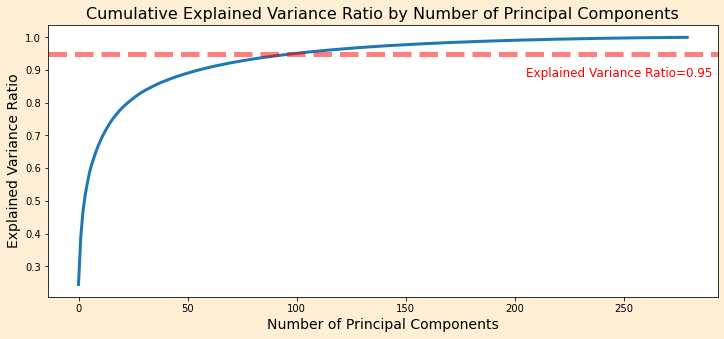

Number of Principal Components needed to explain 95% variance: 100


In [23]:
scaler = StandardScaler()
X_train_ = scaler.fit_transform(X_train)
X_test_ = scaler.fit_transform(X_test)

pca = PCA().fit(X_train)
plt.figure(figsize=(12, 5)).set_facecolor("papayawhip")
plt.plot(pca.explained_variance_ratio_.cumsum(), lw = 3)

plt.axhline(y = 0.95, color = 'red', alpha = 0.5, ls = '--', lw = 5)
plt.xlabel('Number of Principal Components', fontsize = 14)
plt.ylabel('Explained Variance Ratio', fontsize = 14)
plt.title('Cumulative Explained Variance Ratio by Number of Principal Components', fontsize = 16)
plt.text(205, 0.88, "Explained Variance Ratio=0.95", fontsize=12, color='red')
plt.show()

# 計算累計變異為95%的主成分數量
var_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(var_ratio_cumsum >= 0.95) + 1
print(f"Number of Principal Components needed to explain 95% variance: {n_components}")


3. 將標準化後的資料進行主成分分析（PCA），選取不同的優化器與主成份個數（q），並使用 LogisticRegression 進行分類任務，觀察結果。  

          PCA(q=10) PCA(q=20) PCA(q=40) PCA(q=60) PCA(q=100) PCA(q=200)
lbfgs        85.83%    94.17%    96.67%    97.50%     96.67%     96.67%
liblinear    73.33%    92.50%    93.33%    93.33%     92.50%     92.50%
newton-cg    85.83%    94.17%    96.67%    97.50%     96.67%     96.67%


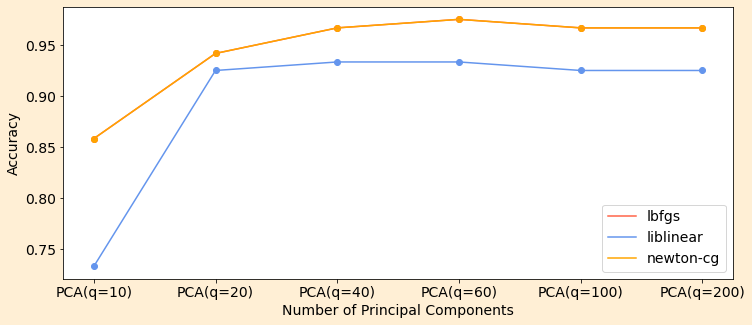

In [36]:
q = [10,20,40,60,100,200]
solver = ['lbfgs', 'liblinear', 'newton-cg'] 
opts = dict(tol = 1e-6, max_iter = int(1e6), verbose = 0)
results = {}
for n in q:
    pca = PCA(n_components=n).fit(X_train_)
    Z_train = pca.transform(X_train_)
    Z_test = pca.transform(X_test_)
    solver_results = {}
    for x in solver:
        clf_PCA = LogisticRegression(solver = x, **opts)
        accuracy = clf_PCA.fit(Z_train, y_train).score(Z_test, y_test)
        solver_results[x] = accuracy
    results[f"PCA(q={n})"] = solver_results

df = pd.DataFrame(results)
print(df.applymap(lambda x: '{:.2%}'.format(x)))

# 折線圖
plt.figure(figsize=(12, 5)).set_facecolor("papayawhip")
x = df.columns.values
colors = ['tomato', 'cornflowerblue', 'orange']

for i, solver in enumerate(df.index):
    accuracy = df.loc[solver].values
    plt.plot(x, accuracy, color=colors[i], label=solver)
    plt.scatter(x, accuracy, color=colors[i])
plt.gca().set_facecolor('white')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


- 『L-BFGS』與『Newton-CG』學習器在不同的主成份個數選取下有相同的分類準確率(黃色折線圖)，隨著主成份個數選取的增加，有更高的準確率，但是成長的幅度趨緩。
- 『LIBLINEAR』學習器在主成份個數選取為10的情況下，準確率較低（藍色折線圖），但是隨著主成份個數增加準確率的上升幅度較為明顯，當主成份個數取到60後，分類準確率反而下降，可能是模型過度擬合（overfitting），當樣本數較少時，容易導致測試集上的表現不如訓練集。 
- 主成分個數為60時，『L-BFGS』與『Newton-CG』學習器的分累準確率有很最高的準確率 ( 97.5% )

#### 二、支援向量機（Support Vector Machine）

1. 將原始資料使用線性核函數（linear）透過支援向量機進行分類任務  
- 正規劃參數：c = 1
- 分類方式：one vs one (ovo)
- 核函數：線性核函數（linear）   

&rarr; 原始資料的分類準確率高達95%

In [25]:
C = 1 
opts = dict(C = C, decision_function_shape = "ovo",tol = 1e-6, max_iter = int(1e6))
clf_svm = SVC(kernel = "linear", gamma = 0.2, **opts)
clf_svm.fit(X_train, y_train)
y_pred = clf_svm.predict(X_test) 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      1.00      1.00         3
           2       0.75      1.00      0.86         3
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         2
           9       1.00      0.67      0.80         3
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         4
          12       1.00      0.50      0.67         4
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00         1
          15       1.00      0.75      0.86         4
          16       1.00      1.00      1.00         2
          17       1.00    

由於第13個人與第29個人的 f1-score 特別低，因此將他們的所有照片還原，進一步觀察是否有明顯的特徵造成分類表現不佳。在第一小節多元羅吉斯迴歸分析中並沒有發現這項差異。

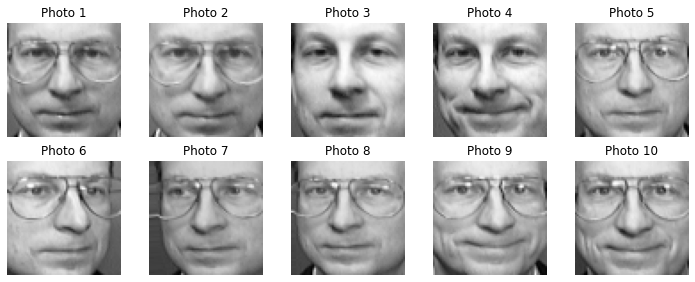

In [28]:
person_num = 12
photos = X[np.where(y == person_num)[0]]

fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i in range(2):
    for j in range(5):
        axs[i, j].imshow(photos[i*5+j].reshape(64, 64), cmap='gray')
        axs[i, j].set_title(f"Photo {i*5+j+1}")
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()

&rarr; 從圖像觀察可以發現，這個人的照片有些戴眼鏡，有些沒有戴眼鏡，眼神看的位置也不一致，有的照片因為抿嘴導致多了皺紋（Photo 4），這些因素都可能導致分類表現不佳。

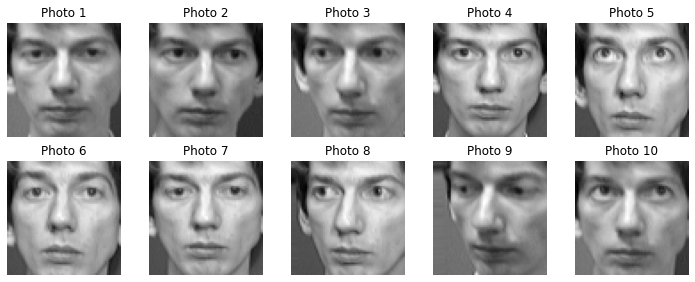

In [29]:
person_num = 28

photos = X[np.where(y == person_num)[0]]

fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i in range(2):
    for j in range(5):
        axs[i, j].imshow(photos[i*5+j].reshape(64, 64), cmap='gray')
        axs[i, j].set_title(f"Photo {i*5+j+1}")
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()

&rarr; 從圖片可以觀察到，這位人物的照片中眼神凝視方向和臉部角度存在一定的差異。此外，有張照片眼神模糊不清（Photo 9），這些因素可能會對分類表現造成一定的影響。

2. 將標準化後的資料(X_train_、X_test_)進行主成分分析（PCA）降維，並使用 SVC 與 LinearSVC 進行分類任務。   

In [30]:
pca = PCA(n_components = 60).fit(X_train_)
Z_train = pca.transform(X_train_)
Z_test = pca.transform(X_test_)
opts = dict(C = C,tol = 1e-6, max_iter = int(1e6))
clf_svm = SVC(kernel="linear", gamma = 0.2, **opts) 
print(f"SVM : {clf_svm.fit(Z_train, y_train).score(Z_test, y_test):.2%}\n")

clf_svm = LinearSVC(**opts) 
print(f"LinearSVM : {clf_svm.fit(Z_train, y_train).score(Z_test, y_test):.2%}\n")

SVM : 94.17%

LinearSVM : 93.33%



    比較不同的核函數與主成份個數對分類結果的不同
- 線性 ( kernel = 'linear' )
- 多項式 ( kernel = 'poly' )
- 高斯基函數 ( kernel = 'rbf' ) 

       PCA(q=10) PCA(q=20) PCA(q=40) PCA(q=60) PCA(q=100) PCA(q=200)
linear    89.17%    93.33%    95.00%    94.17%     93.33%     95.00%
poly      80.83%    80.00%    83.33%    82.50%     76.67%     70.83%
rbf        2.50%     1.67%     1.67%     1.67%      1.67%      3.33%


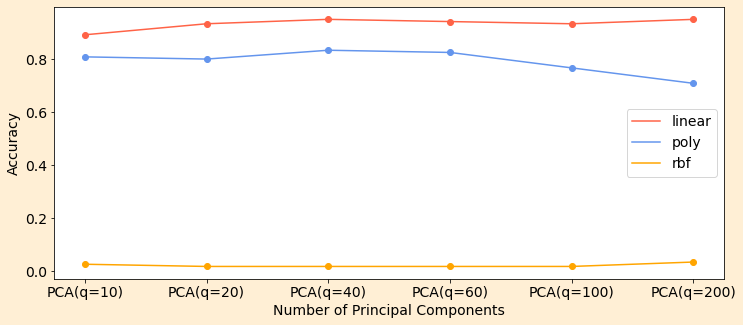

In [39]:
q = [10,20,40,60,100,200]
kernel = ['linear', 'poly', 'rbf'] 
opts = dict(C = C,tol = 1e-6, max_iter = int(1e6))
 
results = {}
for n in q:
    pca = PCA(n_components = n).fit(X_train_)
    Z_train = pca.transform(X_train_)
    Z_test = pca.transform(X_test_)
    solver_results = {}
    for x in kernel:
        clf_svm = SVC(kernel=x, gamma = 0.2, **opts)
        accuracy = clf_svm.fit(Z_train, y_train).score(Z_test, y_test)
        solver_results[x] = accuracy
    results[f"PCA(q={n})"] = solver_results

df = pd.DataFrame(results)
print(df.applymap(lambda x: '{:.2%}'.format(x)))

# 折線圖
plt.figure(figsize=(12, 5)).set_facecolor("papayawhip")
x = df.columns.values
colors = ['tomato', 'cornflowerblue', 'orange']

for i, solver in enumerate(df.index):
    accuracy = df.loc[solver].values
    plt.plot(x, accuracy, color=colors[i], label=solver)
    plt.scatter(x, accuracy, color=colors[i])
plt.gca().set_facecolor('white')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


- 分類準確率的表現，『linear』核函數為第一名，其次『poly』核函數，再來是『rbf』核函數
- 使用『linear』核函數的分類準確率中，以主成分個數為40時有最高的準確率（95%）
- 使用『poly』核函數的分類準確率中，以主成分個數為40時有最高的準確率（83.33%），接著隨著主成分個數增加而下降，可能是模型過度擬合（overfitting）。
- 使用『rbf』核函數的分類準確率都很低，可能是因為RBF核函數不能很好的擬合此資料集

#### 三、神經網路（Neural network）
1. MLPClassifier建立一個多層感知機模型，原始資使用以下參數料訓練模型
- 隱藏層的神經元數量（hidden_layers）：一層30個神經元
- 學習器（solver）：adam
- 優化函數（activation）: logistic

&rarr; 隱藏層使用30個神經元，採用『adam』學習器以及『logistic』優化函數。經過訓練後，模型在測試集上的準確率為98.33%。此外，當迭代次數達到500次時，損失函數的值逐漸下降並趨於穩定，顯示出此訓練過程相對穩定。

Accuracy : 98.33%



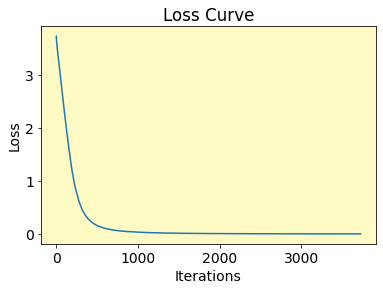

In [46]:
hidden_layers = (30,)
activation = 'logistic'
opts = dict(hidden_layer_sizes = hidden_layers, verbose = False, activation = activation, tol = 1e-6, max_iter = int(1e6))

solver = 'adam'
clf_MLP = MLPClassifier(solver = solver, **opts) 
print(f"Accuracy : {clf_MLP.fit(X_train, y_train).score(X_test, y_test):.2%}\n")
plt.gca().set_facecolor('#FFF9C4')
plt.plot(clf_MLP.loss_curve_)
plt.title('Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

2. 使用標準化後的資料進行主成分分析（PCA）降維，並採用MLPClassifier進行人臉辨識的分類任務。為了探討不同參數對分類結果的影響，選擇30個神經元與『adam』學習器，實驗不同主成分個數與優化函數的組合
 
- 隱藏層的神經元數量（hidden_layers）：一層30個神經元
- 學習器（solver）：adam

In [62]:
q = [10,20,40,60,100,200]
activation = ['identity', 'logistic', 'relu', 'tanh']
opts = dict(hidden_layer_sizes = (30,),solver = 'adam', verbose = False, tol = 1e-6, max_iter = int(1e6))
results = {}
for n in q:
    pca = PCA(n_components = n).fit(X_train_)
    Z_train = pca.transform(X_train_)
    Z_test = pca.transform(X_test_)
    solver_results = {}
    for x in activation:
        clf_MLP_PCA = MLPClassifier(activation = x, **opts) 
        accuracy = clf_MLP_PCA.fit(Z_train, y_train).score(Z_test, y_test)
        solver_results[x] = accuracy
    results[f"PCA(q={n})"] = solver_results

df = pd.DataFrame(results)
df.applymap(lambda x: '{:.2%}'.format(x))

,PCA(q=10),PCA(q=20),PCA(q=40),PCA(q=60),PCA(q=100),PCA(q=200)
identity,88.33%,90.83%,88.33%,86.67%,88.33%,80.83%
logistic,83.33%,91.67%,90.83%,90.83%,90.83%,93.33%
relu,80.83%,81.67%,85.00%,83.33%,84.17%,85.83%
tanh,80.00%,82.50%,82.50%,85.83%,92.50%,87.50%


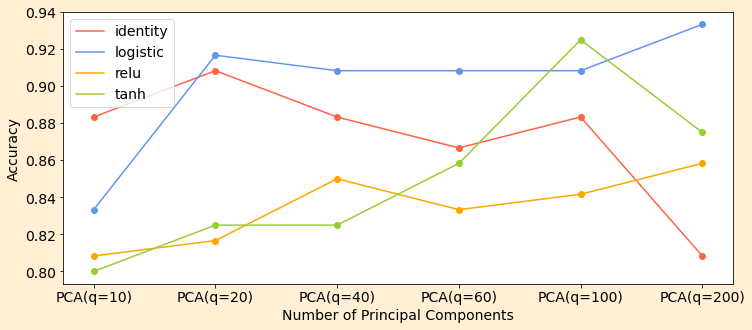

In [65]:
# 折線圖
plt.figure(figsize=(12, 5)).set_facecolor("papayawhip")
x = df.columns.values
colors = ['tomato', 'cornflowerblue', 'orange','yellowgreen']

for i, activation in enumerate(df.index):
    accuracy = df.loc[activation].values
    plt.plot(x, accuracy, color=colors[i], label=activation)
    plt.scatter(x, accuracy, color=colors[i])
plt.gca().set_facecolor('white')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

    結果
- 使用『adam』優化函數，隨著主成份個數的增加，準確率有下降的趨勢，尤其是選擇200個主成分的資料準確率下降為80.83%，可能是模型過度擬合（overfitting）。  
- 使用『logistic』優化函數，隨著主成份個數的增加，準確率有上升的趨勢。其中，主成分個數介於20至100有相近的準確率，且皆高於其他優化函數。  
- 使用『relu』優化函數，隨著主成份個數的增加，準確率有上升的趨勢，且差距不大皆介於80%至90%。  
- 使用『tanh』優化函數，隨著主成份個數的增加，準確率有上升的趨勢，且在主成分個數為100時有最高的準確率(92.5%)。


3. 從上述的結果，選擇兩種資料，並且改變隱藏層個數與激活函數，嘗試改善分類準確率 
- 實驗一：
    - 主成分個數：100
    - 優化函數：tanh

      hidden_layer=(30,) hidden_layer=(50,) hidden_layer=(100,)
adam              87.50%             85.83%              90.83%
sgd               90.00%             85.00%              90.00%
lbfgs             90.00%             95.83%              95.00%


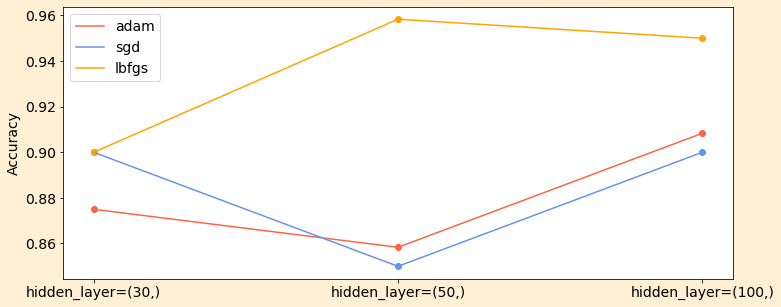

In [71]:
pca = PCA(n_components = 100).fit(X_train_)
Z_train = pca.transform(X_train_)
Z_test = pca.transform(X_test_)
solver = ['adam','sgd','lbfgs'] 
hidden_layer = [(30,), (50,),(100,)]
opts = dict(activation = 'tanh', verbose = False, tol = 1e-6, max_iter = int(1e6))
results = {}
for n in hidden_layer:
    solver_results = {}
    for x in solver:
        clf_MLP_PCA = MLPClassifier(solver = x,hidden_layer_sizes = n, **opts) 
        accuracy = clf_MLP_PCA.fit(Z_train, y_train).score(Z_test, y_test)
        solver_results[x] = accuracy
    results[f"hidden_layer={n}"] = solver_results

df = pd.DataFrame(results)
print(df.applymap(lambda x: '{:.2%}'.format(x)))

# 折線圖
plt.figure(figsize=(12, 5)).set_facecolor("papayawhip")
x = df.columns.values
colors = ['tomato', 'cornflowerblue', 'orange']

for i, solver in enumerate(df.index):
    accuracy = df.loc[solver].values
    plt.plot(x, accuracy, color=colors[i], label=solver)
    plt.scatter(x, accuracy, color=colors[i])
plt.gca().set_facecolor('white')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

&rarr; 神經元個數提高至50時，『lbfgs』學習器有最高的準確率（95.83%）。神經元個數提高至100時，『lbfgs』學習器有最高的準確率（95%）。

- 實驗二：
    - 主成分個數：40
    - 優化函數：logistic

      hidden_layer=(30,) hidden_layer=(50,) hidden_layer=(100,)
adam              92.50%             95.83%              94.17%
sgd               92.50%             94.17%              96.67%
lbfgs             90.83%             95.00%              98.33%


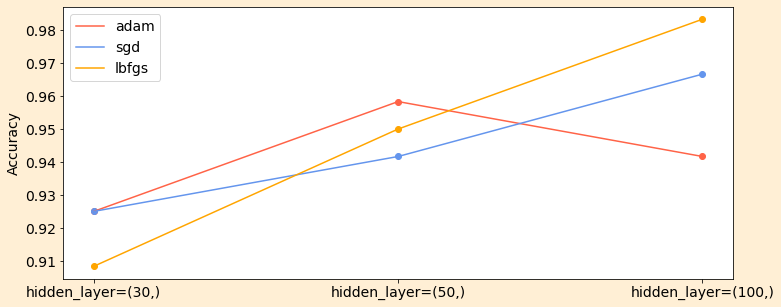

In [73]:
pca = PCA(n_components = 40).fit(X_train_)
Z_train = pca.transform(X_train_)
Z_test = pca.transform(X_test_)
solver = ['adam','sgd','lbfgs'] 
hidden_layer = [(30,), (50,),(100,)]
opts = dict(activation = 'logistic', verbose = False, tol = 1e-6, max_iter = int(1e6))
results = {}
for n in hidden_layer:
    solver_results = {}
    for x in solver:
        clf_MLP_PCA = MLPClassifier(solver = x,hidden_layer_sizes = n, **opts) 
        accuracy = clf_MLP_PCA.fit(Z_train, y_train).score(Z_test, y_test)
        solver_results[x] = accuracy
    results[f"hidden_layer={n}"] = solver_results

df = pd.DataFrame(results)
print(df.applymap(lambda x: '{:.2%}'.format(x)))

# 折線圖
plt.figure(figsize=(12, 5)).set_facecolor("papayawhip")
x = df.columns.values
colors = ['tomato', 'cornflowerblue', 'orange']

for i, solver in enumerate(df.index):
    accuracy = df.loc[solver].values
    plt.plot(x, accuracy, color=colors[i], label=solver)
    plt.scatter(x, accuracy, color=colors[i])
plt.gca().set_facecolor('white')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

    結論：
- 在多元羅吉斯迴歸中，主成分個數為60，學習器為『L-BFGS』與『Newton-CG』，能夠獲得最高的分類準確率 (97.5%)。
- 在支援向量機中，使用『linear』核函數的與40個主成分有最高的準確率（95%）。此外，使用『rbf』核函數的分類準確率都很低。
- 在神經網路中，主成分個數為30，優化函數為『logistic』，學習器為『lbfgs』，隱藏層的神經元數量為100，能夠獲得最高的分類準確率 （98.33%）。

&rarr; 總體而言，針對這個資料集，使用神經網路演算法得到的分類準確率最好。然而，由於樣本抽樣的影響，這個結果只能呈現相對的準確率比較，想進一步比較不同演算法之間的差異，可以使用重複抽樣再取平均值的方式來探討分類結果。